In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import njit
#note: cn method uses a jit compiler-> to obtain similar resuts run the cells 2 times 
#(the 1st time would be affected by compile time )

In [2]:
def fd_american_pricing_explicit(k,r,sigma,T,dt,ds,s_max,put=True,american=True):
    #explicit fd scheme for American option
    
    if sigma**2 *s_max**2*dt /ds**2>1:
        raise Exception("unstable parameters")
    t_count=int(T/dt)+1
    s_count=int(s_max/ds)+1


    t_lin=np.linspace(0,T,t_count)

    x_lin=np.linspace(0,s_max,s_count)
    
    j_index=np.arange(0,len(x_lin)+1)

    if put:
        payoff=lambda s: np.maximum(k-s,0)
    else:
        payoff=lambda s: np.maximum(s-k,0)

    value=np.zeros((s_count,t_count))
    #Terminal condition
    value[:,t_count-1]=payoff(x_lin)
    
    if put:
        #left boundary condition
        value[0,:]=k
        #rigth boundary condition
        value[s_count-1,:]=0
    else:
        #left boundary condition
        value[0,:]=0
        #rigth boundary condition
        value[s_count-1,:]=s_max-k*np.exp(-r*(T-t_lin))


    #FD coefficient
    a=0.5*dt*(sigma**2*j_index[1:s_count-1]**2-r*j_index[1:s_count-1])
    
    b=1-dt*(sigma**2*j_index[1:s_count-1]**2+r)

    c= 0.5*dt*(sigma**2*j_index[1:s_count-1]**2+r*j_index[1:s_count-1])
    
    if american:
        for i in range(t_count-2,-1,-1):
            value[1:s_count-1,i]=np.maximum(a*value[0:s_count-2,i+1]+ b*value[1:s_count-1,i+1] + c*value[2:s_count,i+1],
                                            payoff(x_lin[1:s_count-1]))
    else:
        for i in range(t_count-2,-1,-1):
            value[1:s_count-1,i]=a*value[0:s_count-2,i+1]+ b*value[1:s_count-1,i+1] + c*value[2:s_count,i+1]
        
    return value[:,0]




In [3]:
@njit
def PSOR_FD(B,F,g,sol_0,omega,american,epsilon=10**-8,max_iter=1000):
    n=len(F)
    v_1=np.copy(sol_0)
    v=np.copy(sol_0)
    if american:
        for i in range(max_iter):
            v[0]=max(v[0]*(1-omega)+omega/B[0,0]*(F[0]-B[0,1]*v[1]),g[0])
            for j in range(1,n-1):
                v[j]=max(v[j]*(1-omega)+omega/B[j,j]*(F[j]-B[j,j-1]*v[j-1]-B[j,j+1]*v[j+1]),g[j])
            v[n-1]=max(v[n-1]*(1-omega)+omega/B[n-1,n-1]*(F[n-1]-B[n-1,n-2]*v[n-2]),g[n-1])

            if np.linalg.norm(v-v_1)/np.sqrt(n)<epsilon:
                break

            v_1[:]=v
    else:
        for i in range(max_iter):
            v[0]=v[0]*(1-omega)+omega/B[0,0]*(F[0]-B[0,1]*v[1])
            for j in range(1,n-1):
                v[j]=v[j]*(1-omega)+omega/B[j,j]*(F[j]-B[j,j-1]*v[j-1]-B[j,j+1]*v[j+1])
            v[n-1]=v[n-1]*(1-omega)+omega/B[n-1,n-1]*(F[n-1]-B[n-1,n-2]*v[n-2])

            if np.linalg.norm(v-v_1)/np.sqrt(n)<epsilon:
                break

            v_1[:]=v
    

    return (v,i)


def fd_american_pricing_cn(k,r,sigma,T,dt,ds,s_max,omega=1.5,put=True,american=True):

    t_count=int(T/dt)+1
    s_count=int(s_max/ds)+1


    t_lin=np.linspace(0,T,t_count)

    x_lin=np.linspace(0,s_max,s_count)
    j_index=np.arange(0,len(x_lin)+1)


    if put:
        payoff=lambda s: np.maximum(k-s,0)
    else:
        payoff=lambda s: np.maximum(s-k,0)

    value=np.zeros((s_count,t_count))

    #Terminal condition
    value[:,t_count-1]=payoff(x_lin)
    if put:
        #left boundary condition
        value[0,:]=k
        #rigth boundary condition
        value[s_count-1,:]=0
    else:
        #left boundary condition
        value[0,:]=0
        #rigth boundary condition
        value[s_count-1,:]=s_max-k*np.exp(-r*(T-t_lin))
    
    a=0.25*dt*(sigma**2*j_index[1:s_count-1]**2-r*j_index[1:s_count-1])

    b=-0.5*dt*(sigma**2*j_index[1:s_count-1]**2+r)

    c= 0.25*dt*(sigma**2*j_index[1:s_count-1]**2+r*j_index[1:s_count-1])


    B=np.zeros((s_count-2,s_count-2))
    C=np.zeros((s_count-2,s_count-2))


    for i in range(s_count-2):
        if i==0:
            B[i,i]=1-b[i]
            B[i,i+1]=-c[i]

            C[i,i]=1+b[i]
            C[i,i+1]=c[i]
        if i==s_count-3:
            B[i,i]=1-b[i]
            B[i,i-1]=-a[i]

            C[i,i]=1+b[i]
            C[i,i-1]=a[i]
        else:
            B[i,i]=1-b[i]
            B[i,i+1]=-c[i]
            B[i,i-1]=-a[i]

            C[i,i]=1+b[i]
            C[i,i+1]=c[i]
            C[i,i-1]=a[i]

    aux=np.zeros(s_count-2)
    terminal_condition=value[1:-1,t_count-1]
    discount=np.exp(-T*r/t_count)

    
    iter_array=np.zeros(t_count-2)
    
    for i in range(t_count-2,-1,-1):
        #boundary conditions 
        aux[0]=a[0]*(value[0,i]+value[0,i+1])
        aux[-1]=c[-1]*(value[-1,i]+value[-1,i+1])
        #Ax_t=F F=C*X_{t+1}+K_{T+1}
        F=C.dot(value[1:s_count-1,i+1])+aux
        #discounted value of the option in the last time step as the 1st aproximation to the solver
        value[1:s_count-1,i],iter_value= PSOR_FD(B,F,terminal_condition,discount*value[1:s_count-1,i+1],omega,american)
        iter_array[i-1]=iter_value
                
    return value[:,0],iter_array


In [4]:
def binnary_american_pricing_1_d(k,r,sigma,T,n,s0,put=True,american=True):
    #binary trees  for American option

    u=np.exp(sigma*((T/n)**0.5))
    d=1/u
    discount=np.exp(-T*r/n)
    
    #risk neutral probability
    q=(np.exp(r*T/n)-d)/(u-d)
    
    option=np.zeros((n+1,n+1))

    
    if put:
        payoff=lambda s: np.maximum(k-s,0)
    else:
        payoff=lambda s: np.maximum(s-k,0)
    
    if american:
    #prices lattice
        lattice=np.zeros((n+1,n+1))

        for i in range(n + 1):
            j=np.arange(0,i+1)
            lattice[j, i] = s0*(u**(i - j))*(d**j)

    
        option[0:n+1,n]=payoff(lattice[0:n+1,n])

        for i in range(n-1,-1,-1):
            option[0:i+1,i]=np.maximum((discount*(q*option[0:i+1,i+1]+(1-q)*option[1:i+2,i+1])),payoff(lattice[0:i+1,i]))
    else:
        
        j=np.arange(0,n+1)
        option[0:n+1,n]=payoff(s0*(u**(n - j))*(d**j))

        for i in range(n-1,-1,-1):
            option[0:i+1,i]=discount*(q*option[0:i+1,i+1]+(1-q)*option[1:i+2,i+1])

    return option[0,0]



In [5]:
def binnary_american_pricing_1_2(k,r,sigma,T,n,s0,put=True,american=True):
    #binary trees  for American option (Jarrow and Rudd (1983))
    
    delta_t=T/n
    u=np.exp((r-sigma**2/2)*delta_t+sigma*np.sqrt(delta_t))
    d=np.exp((r-sigma**2/2)*delta_t-sigma*np.sqrt(delta_t))
    discount=np.exp(-T*r/n)
    option=np.zeros((n+1,n+1))

    #risk neutral probability
    q=1/2
    if put:
        payoff=lambda s: np.maximum(k-s,0)
    else:
        payoff=lambda s: np.maximum(s-k,0)

    if american:
    #prices lattice
        lattice=np.zeros((n+1,n+1))

        for i in range(n + 1):
            j=np.arange(0,i+1)
            lattice[j, i] = s0*(u**(i - j))*(d**j)

    
        option[0:n+1,n]=payoff(lattice[0:n+1,n])

        for i in range(n-1,-1,-1):
            option[0:i+1,i]=np.maximum((discount*(q*option[0:i+1,i+1]+(1-q)*option[1:i+2,i+1])),payoff(lattice[0:i+1,i]))
    else:
        
        j=np.arange(0,n+1)
        option[0:n+1,n]=payoff(s0*(u**(n - j))*(d**j))

        for i in range(n-1,-1,-1):
            option[0:i+1,i]=discount*(q*option[0:i+1,i+1]+(1-q)*option[1:i+2,i+1])

    return option[0,0]



In [6]:
def get_index(values,s_max,ds):
    #function to compute the index of each s_0 in the solution vector of the FD methods
    s_count=int(s_max/ds)+1

    x_lin=np.linspace(0,s_max,s_count)
    index=np.zeros(len(values),dtype=int)
    
    for i in range(len(values)):
        index[i]= np.where(x_lin==values[i])[0]
    return index

s_max=500
s_0=[100]
k=100
sigma=0.2
r=0.05
T=1

1.05
1.1
1.15
1.2
1.25
1.3
1.35
1.4
1.45
1.5
1.55
1.6
1.65
1.7
1.75
1.8
1.85
1.9
1.95


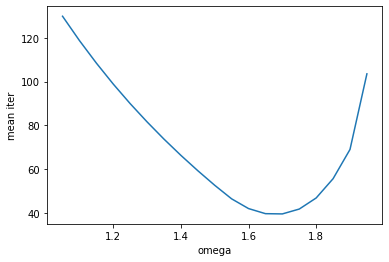

1.65


In [7]:
ds=0.2
dt=ds/50
iter_array=[]
for i in range(1,20):
    print(1+i/20)
    _ , iter_value =fd_american_pricing_cn(k,r,sigma,T,dt,ds,s_max,1+i/20)
    iter_array.append(np.mean(np.array(iter_value)))
plt.plot(1+np.arange(1,20)/20,iter_array)
plt.xlabel("omega")
plt.ylabel("mean iter")
plt.show()

print(np.argmin(np.array(iter_array))/20+1)
    

In [25]:
aux=binnary_american_pricing_1_d(k,r,sigma,T,15000,s_0)
aux_percision=binnary_american_pricing_1_d(k,r,sigma,T,30000,s_0)
print(aux_percision-aux)
#assuming convergence(which the binomial method has) |true-aux_precision|<10^-5
#i.e. good  enough to compare with solutions with 10^-3 percision

2.513798411563073e-05


In [9]:
for ds in [2,1,0.5,0.25,0.1]:
    #https://math.stackexchange.com/questions/3989847/stability-analysis-finite-difference-methods-black-scholes-pde
    dt=ds**2 /(sigma**2 *s_max**2)
    index=get_index(s_0,s_max,ds)
    solution=fd_american_pricing_explicit(k,r,sigma,T,dt,ds,s_max)[index]
    if(np.abs(aux_percision-solution)<10**-3):
        print("final ds explicit",ds,np.abs(aux_percision-solution))
        break
    print(ds,np.abs(aux_percision-solution))

for n in [100,200,300,400,500,600,700,800,900,1000]:
    solution=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0)
    if(np.abs(aux_percision-solution)<10**-3):
        print("final n binomial d",n,np.abs(aux_percision-solution))
        break
    print(n,np.abs(aux_percision-solution))

for n in [100,200,300,400,500,600,700,800,900,1000]:
    solution=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0)
    if(np.abs(aux_percision-solution)<10**-3):
        print("final n binomial p",n,np.abs(aux_percision-solution))
        break
    print(n,np.abs(aux_percision-solution))    
    
for ds in [2,1,0.5,0.25,0.1]:
    dt=ds/50
    index=get_index(s_0,s_max,ds)
    solution,iter_array =fd_american_pricing_cn(k,r,sigma,T,dt,ds,s_max,1.65)
    if(np.abs(aux_percision-solution[index])<10**-3):
        print("final ds cn",ds,np.abs(aux_percision-solution[index]))
        break
    print(ds,np.abs(aux_percision-solution[index]))

#ds explicit= 0.5
#n binomial 1/d = 800
#n binomial 1/2 =600
#ds explicit= 0.5

2 [0.01073135]
1 [0.00270669]
final ds explicit 0.5 [0.00066027]
100 0.007991331154303616
200 0.003962990380685483
300 0.0026231259286308983
400 0.0019398432576842595
500 0.0015356295937110076
600 0.0012678808737858205
700 0.001084959623034898
final n binomial d 800 0.0009441249618431513
100 0.009689192391499901
200 0.003022564616506962
300 0.0029160906376901607
400 0.0035107987055740253
500 0.002434646426101139
final n binomial p 600 0.0008044714233284012
2 [0.01163448]
1 [0.00336769]
final ds cn 0.5 [0.00096441]


In [10]:
n=800
time_aux=time.time()
binnary_solution=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0)
print("time binary u=1/d:", time.time()-time_aux)

n=600
time_aux=time.time()
binnary_solution=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0)
print("time binary p=0.5:", time.time()-time_aux)

ds=0.5
dt=ds**2 /(sigma**2 *s_max**2)
index=get_index(s_0,s_max,ds)
time_aux=time.time()
explicit_solution=fd_american_pricing_explicit(k,r,sigma,T,dt,ds,s_max)
print("time explicit:", time.time()-time_aux)

ds=0.5
dt=ds/50
index=get_index(s_0,s_max,ds)
time_aux=time.time()
cn_solution,iter_array =fd_american_pricing_cn(k,r,sigma,T,dt,ds,s_max,1.65)
print("time cn:", time.time()-time_aux)

time binary u=1/d: 0.10767936706542969
time binary p=0.5: 0.0688164234161377
time explicit: 1.2323729991912842
time cn: 0.08975958824157715


time binary: 0.7700855731964111
time binary 1_2: 0.5196549892425537


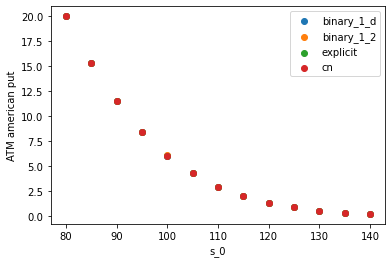

In [11]:
s_0_arr=np.array([80,85,90,95,100,105,110,115,120,125,130,135,140])
n=800

binary_solution_arr=np.zeros(len(s_0_arr))
time_aux=time.time()
for i in range(len(s_0_arr)):
    binary_solution_arr[i]=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0_arr[i])
print("time binary:", time.time()-time_aux)

n=600
binary_solution_arr_1_2=np.zeros(len(s_0_arr))
time_aux=time.time()
for i in range(len(s_0_arr)):
    binary_solution_arr_1_2[i]=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0_arr[i])
print("time binary 1_2:", time.time()-time_aux)


ds=0.5
index=get_index(s_0_arr,s_max,ds)
explicit_solution_arr=explicit_solution[index]

ds=0.5
index=get_index(s_0_arr,s_max,ds)
cn_solution_arr=cn_solution[index]

plt.scatter(s_0_arr,binary_solution_arr)
plt.scatter(s_0_arr,binary_solution_arr_1_2)
plt.scatter(s_0_arr,explicit_solution_arr)
plt.scatter(s_0_arr,cn_solution_arr)
plt.legend(["binary_1_d","binary_1_2","explicit","cn"])
plt.xlabel("s_0")
plt.ylabel("ATM american put")
plt.show()

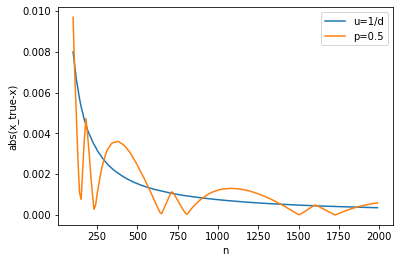

In [26]:
result_1=[]
for n in range(100,2000,10):
    solution=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0)
    result_1.append(np.abs(aux_percision-solution))

result_2=[]
for n in range(100,2000,10):
    solution=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0)
    result_2.append(np.abs(aux_percision-solution)) 

plt.plot(range(100,2000,10),result_1)
plt.plot(range(100,2000,10),result_2)
plt.xlabel("n")
plt.ylabel("abs(x_true-x)")
plt.legend(["u=1/d","p=0.5"])
plt.show()

In [13]:
#European Call

1.05
1.1
1.15
1.2
1.25
1.3
1.35
1.4
1.45
1.5
1.55
1.6
1.65
1.7
1.75
1.8
1.85
1.9
1.95


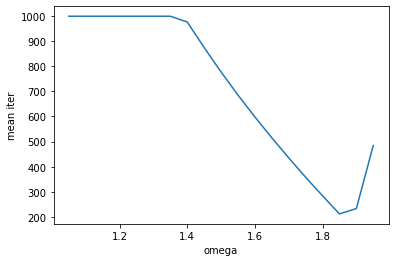

1.8


In [14]:
ds=0.2
dt=ds/50
iter_array=[]
for i in range(1,20):
    print(1+i/20)
    _ , iter_value =fd_american_pricing_cn(k,r,sigma,T,dt,ds,s_max,1+i/20,put=False,american=False)
    iter_array.append(np.mean(np.array(iter_value)))
plt.plot(1+np.arange(1,20)/20,iter_array)
plt.xlabel("omega")
plt.ylabel("mean iter")
plt.show()

print(np.argmin(np.array(iter_array))/20+1)
    

In [15]:
aux=binnary_american_pricing_1_d(k,r,sigma,T,15000,s_0,put=False,american=False)
aux_percision=binnary_american_pricing_1_d(k,r,sigma,T,30000,s_0,put=False,american=False)
print(aux_percision-aux)
#assuming convergence(which the binomial method has) |true-aux_precision|<10^-5
#i.e. good  enough to compare with solutions with 10^-3 percision


6.66564494942179e-05


In [16]:
for ds in [2,1,0.5,0.25,0.1]:
    #https://math.stackexchange.com/questions/3989847/stability-analysis-finite-difference-methods-black-scholes-pde
    dt=ds**2 /(sigma**2 *s_max**2)
    index=get_index(s_0,s_max,ds)
    solution=fd_american_pricing_explicit(k,r,sigma,T,dt,ds,s_max,put=False,american=False)[index]
    if(np.abs(aux_percision-solution)<10**-3):
        print("final ds explicit",ds,np.abs(aux_percision-solution))
        break
    print(ds,np.abs(aux_percision-solution))

for n in [200,400,600,800,1000,1200,1400,1600,1800,2000]:
    solution=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0,put=False,american=False)
    if(np.abs(aux_percision-solution)<10**-3):
        print("final n binomial d",n,np.abs(aux_percision-solution))
        break
    print(n,np.abs(aux_percision-solution))

for n in [100,200,300,400,500,600,700,800,900,1000]:
    solution=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0,put=False,american=False)
    if(np.abs(aux_percision-solution)<10**-3):
        print("final n binomial p",n,np.abs(aux_percision-solution))
        break
    print(n,np.abs(aux_percision-solution))    
    
for ds in [2,1,0.5,0.25,0.1]:
    dt=ds/50
    index=get_index(s_0,s_max,ds)
    solution,iter_array =fd_american_pricing_cn(k,r,sigma,T,dt,ds,s_max,1.8,put=False,american=False)
    if(np.abs(aux_percision-solution[index])<10**-3):
        print("final ds cn",ds,np.abs(aux_percision-solution[index]))
        break
    print(ds,np.abs(aux_percision-solution[index]))

#ds explicit= 0.5
#n binomial 1/d = 2000
#n binomial 1/2 =600
#ds explicit= 0.5

2 [0.00941045]
1 [0.00229949]
final ds explicit 0.5 [0.00052469]
200 0.009925655341588069
400 0.004931073917635587
600 0.0032655121076121674
800 0.0024326003191230683
1000 0.0019328114369550065
1200 0.0015996014455677
1400 0.0013615858062454578
1600 0.0011830694135408493
1800 0.0010442205628216072
final n binomial d 2000 0.0009331397435854427
100 0.009399866914581168
200 0.0052242095658066035
300 0.004164691404826115
400 0.004686512354277639
500 0.002838248695516299
final n binomial p 600 0.00031829272982975
2 [0.00943193]
1 [0.00230521]
final ds cn 0.5 [0.00052616]


In [17]:
n=2000
time_aux=time.time()
binnary_solution=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0,put=False,american=False)
print("time binary u=1/d:", time.time()-time_aux)

n=600
time_aux=time.time()
binnary_solution=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0,put=False,american=False)
print("time binary p=0.5:", time.time()-time_aux)

ds=0.5
dt=ds**2 /(sigma**2 *s_max**2)
index=get_index(s_0,s_max,ds)
time_aux=time.time()
explicit_solution=fd_american_pricing_explicit(k,r,sigma,T,dt,ds,s_max,put=False,american=False)
print("time explicit:", time.time()-time_aux)

ds=0.5
dt=ds/50
index=get_index(s_0,s_max,ds)
time_aux=time.time()
cn_solution,iter_array =fd_american_pricing_cn(k,r,sigma,T,dt,ds,s_max,1.8,put=False,american=False)
print("time cn:", time.time()-time_aux)

time binary u=1/d: 0.09588384628295898
time binary p=0.5: 0.009971380233764648
time explicit: 1.1079161167144775
time cn: 0.3341374397277832


time binary: 0.9792635440826416
time binary: 0.07879352569580078


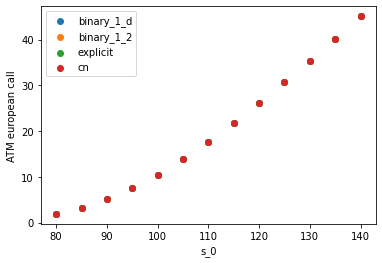

In [18]:
s_0_arr=np.array([80,85,90,95,100,105,110,115,120,125,130,135,140])
n=2000

binary_solution_arr=np.zeros(len(s_0_arr))
time_aux=time.time()
for i in range(len(s_0_arr)):
    binary_solution_arr[i]=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0_arr[i],put=False,american=False)
print("time binary:", time.time()-time_aux)

n=600
binary_solution_arr_1_2=np.zeros(len(s_0_arr))
time_aux=time.time()
for i in range(len(s_0_arr)):
    binary_solution_arr_1_2[i]=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0_arr[i],put=False,american=False)
print("time binary:", time.time()-time_aux)


ds=0.5
index=get_index(s_0_arr,s_max,ds)
explicit_solution_arr=explicit_solution[index]

ds=0.5
index=get_index(s_0_arr,s_max,ds)
cn_solution_arr=cn_solution[index]

plt.scatter(s_0_arr,binary_solution_arr)
plt.scatter(s_0_arr,binary_solution_arr_1_2)
plt.scatter(s_0_arr,explicit_solution_arr)
plt.scatter(s_0_arr,cn_solution_arr)
plt.legend(["binary_1_d","binary_1_2","explicit","cn"])
plt.xlabel("s_0")
plt.ylabel("ATM european call")
plt.show()

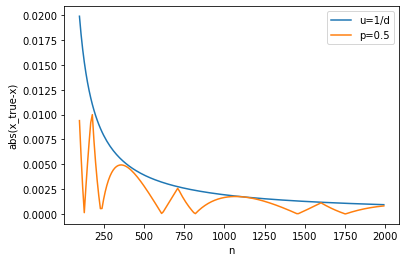

In [24]:
result_1=[]
for n in range(100,2000,10):
    solution=binnary_american_pricing_1_d(k,r,sigma,T,n,s_0,put=False,american=False)
    result_1.append(np.abs(aux_percision-solution))

result_2=[]
for n in range(100,2000,10):
    solution=binnary_american_pricing_1_2(k,r,sigma,T,n,s_0,put=False,american=False)
    result_2.append(np.abs(aux_percision-solution)) 

plt.plot(range(100,2000,10),result_1)
plt.plot(range(100,2000,10),result_2)
plt.xlabel("n")
plt.ylabel("abs(x_true-x)")
plt.legend(["u=1/d","p=0.5"])
plt.show()